In [1]:
import os
import shutil
import warnings

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

from train import create_net
from utils import transforms as MT
from utils.datasets import AortaDataset3DCenter
from utils.eval import eval_net

warnings.filterwarnings("ignore")
np.random.seed(63910)
torch.manual_seed(53152)
torch.cuda.manual_seed_all(7987)
torch.backends.cudnn.deterministic = True

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
n_channels, n_classes, batch_size = 1, 3, 128

transform = T.Compose([
    MT.Resize3D(81),
    MT.CenterCrop3D(81),
    MT.ToTensor3D(),
    #MT.SobelChannel(3, True),
])

train = AortaDataset3DCenter('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/center/train/', transform=transform, depth=7)
val = AortaDataset3DCenter('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/center/val/', transform=transform, depth=7)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)

[INFO]: Creating dataset with 58162 examples. Depth:7, Step:1, Residual:False
[INFO]: Creating dataset with 13110 examples. Depth:7, Step:1, Residual:False


In [ ]:
n_channels, n_classes, batch_size = 1, 4, 128

transform = T.Compose([
    T.Resize(81), # 缩放图片(Image)，保持长宽比不变，最短边为img_size像素
    T.CenterCrop(81), # 从图片中间切出img_size*img_size的图片
    T.ToTensor(), # 将图片(Image)转成Tensor，归一化至[0, 1]
])

train = ImageFolder('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/', transform=transform, loader=lambda path: Image.open(path))
val = ImageFolder('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/', transform=transform, loader=lambda path: Image.open(path))
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)

In [3]:
net = create_net(device, 'resnet', 34, n_channels, n_classes, 'details/checkpoints/CrossEntropy/01-12_14:38:41/Net_best.pth', entire=True, flag_3d=True)
net.eval()
print('')

[INFO]: **********************************************************************
Network: ResNet3D_34
	1 input channels
	3 output channels (classes)
	3D model: True

[INFO]: Model loaded from details/checkpoints/CrossEntropy/01-12_14:38:41/Net_best.pth



In [4]:
class HookModule:
    def __init__(self, model, module):
        self.model = model
        self.handle = module.register_forward_hook(self._get_output)
        
    def _get_output(self, module, inputs, outputs):
        self.outputs = outputs
    
    def grads(self, outputs, retain_graph=True, create_graph=True):
        grads = torch.autograd.grad(outputs=outputs, inputs=self.outputs, retain_graph=retain_graph, create_graph=create_graph)
        self.model.zero_grad()
        print(grads[0].shape)
        return grads[0]
    
    def remove(self):
        self.handle.remove()
        
hook = HookModule(net, net.encoder.layer4[2].conv2)

In [ ]:
hook.remove()

In [8]:
def get_grads(dataset, dataloader, end=500, start=0):
    idx = 0
    score_list = [[] for _ in range(n_classes)]
    err_list = [[] for _ in range(n_classes)]
    for imgs, true_categories in tqdm(dataloader, total=len(dataloader), desc='Dataset', unit='batch', leave=False):
        imgs = imgs.to(device=device, dtype=torch.float32)
        true_categories = true_categories.to(device=device, dtype=torch.long)

        with torch.no_grad():
            categories_pred = torch.softmax(net(imgs), dim=1)
            labels_pred = categories_pred.argmax(dim=1)
            for i in range(len(true_categories)):
                if labels_pred[i] == true_categories[i]:
                    score_list[true_categories[i].item()].append((categories_pred[i, labels_pred[i]].item(), idx))
                else:
                    #err_list[true_categories[i].item()].append(dataset.samples[idx][0])
                    pass
                idx += 1
    
    grad_list = []
    mask_list = []
    for i in range(n_classes):
        print(len(score_list[i]))
        score_list[i].sort(key=lambda x: x[0], reverse=True)
        print(score_list[i][end-1])
        idx_list = [score[1] for score in score_list[i][start: end]]
        tensor_list = []
        for idx in idx_list:
            tensor_list.append(dataset[idx][0])
        batch = torch.stack(tensor_list, dim=0)
        pred = net(batch.to(device))
        nll_loss = F.nll_loss(pred, (torch.ones(batch.size(0))*i).to(device, dtype=torch.long))
        grads = hook.grads(-nll_loss, True, False)
        nll_loss.backward()
        grads = F.relu(grads).sum(dim=(2,3,4)).mean(dim=0)#grads = grads.abs().sum(dim=(2,3,4)).mean(dim=0)
        #grads = F.relu(grads).sum(dim=(2,3)).mean(dim=0)
        print(grads.shape)
        grad_list.append(grads.cpu().numpy())
        mask = (grads>grads.mean()).long()
        mask_list.append(mask.cpu().numpy())

    grads = np.array(grad_list)
    masks = np.array(mask_list)
    return grads, masks, err_list

In [9]:
grads, masks, err_list = get_grads(train, train_loader, 500)

31992
(1.0, 991)
torch.Size([500, 512, 1, 3, 3])
torch.Size([512])
21303
(1.0, 33885)
torch.Size([500, 512, 1, 3, 3])
torch.Size([512])
4858
(1.0, 54915)
torch.Size([500, 512, 1, 3, 3])
torch.Size([512])


In [ ]:
# for i in range(n_classes):
#     print(len(err_list[i]))
#     outpath = os.path.join('/nfs3-p2/zsxm/dataset/aorta_classify_ct_-100_500/err_imgs', str(i))
#     os.makedirs(outpath, exist_ok=True)
#     for img in err_list[i]:
#         shutil.copy(img, os.path.join(outpath, img.split('/')[-1]))

[[          0      0.1669           0 ...           0           0     0.38637]
 [    0.34067           0     0.13969 ...     0.36094           0    0.057075]
 [   0.044224           0    0.015059 ...           0    0.065573           0]]


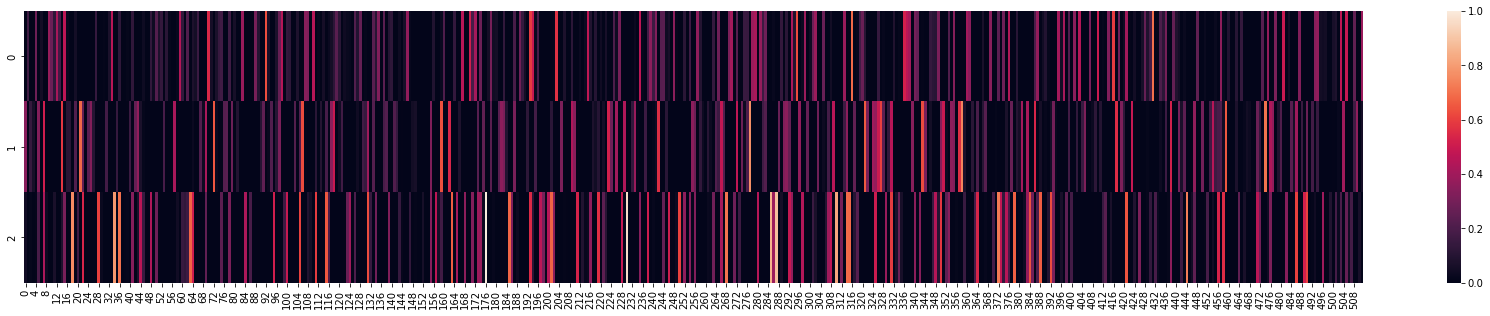

In [10]:
hm = grads - np.min(grads)
hm = hm / np.max(hm)
print(hm)

def view_grads(grads, fig_w, fig_h, fig_path='./heatmap.png'):
    f, ax = plt.subplots(figsize=(fig_w, fig_h), ncols=1)
    ax.set_xlabel('convolutional kernel')
    ax.set_ylabel('category')
    sns.heatmap(grads, annot=False, ax=ax)
    plt.savefig(fig_path, bbox_inches='tight')
    plt.show()
    #plt.clf()
    
view_grads(hm, 30, 5)

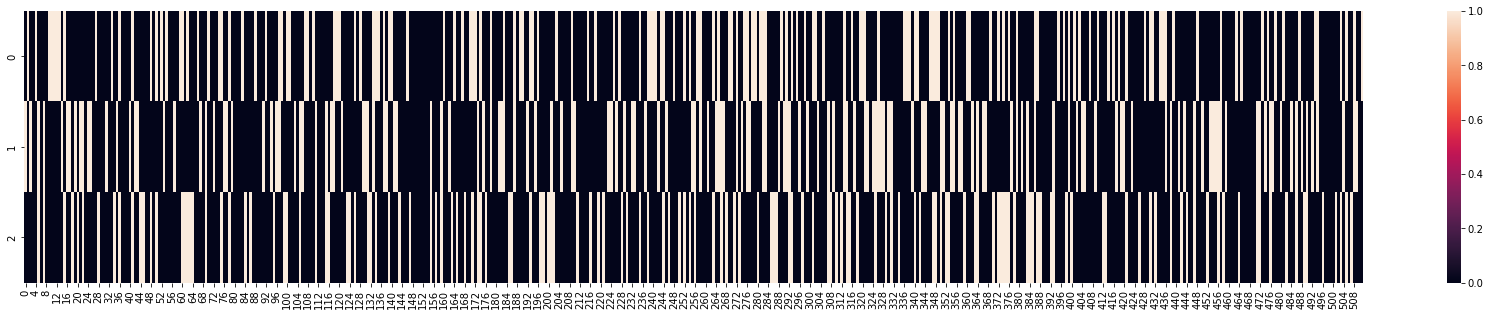

In [11]:
view_grads(masks, 30, 5)

In [12]:
np.save('/nfs3-p2/zsxm/ModelDoctor/3d_pos_conv2.npy', masks)

In [ ]:
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
class ForwardDoctor:
    def __init__(self, model, module):
        self.model = model
        self.handle = module.register_forward_hook(self._modify_output)
        
    def _modify_output(self, module, inputs, outputs):
        channel_sum = outputs.sum(dim=(2,3), keepdim=True) #[batch_size, channel, 1, 1]
        channel_mean = channel_sum.mean(dim=1, keepdim=True) #[batch_size, 1, 1, 1]
        channel_weight = F.sigmoid(channel_sum-channel_mean) #[batch_size, channel, 1, 1]
        outputs = outputs * channel_weight
        return outputs
    
    def remove(self):
        self.handle.remove()

In [ ]:
hook = ForwardDoctor(net, net.encoder.layer4[2].conv2)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
hook2 = ForwardDoctor(net, net.encoder.layer4[2].conv1)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
hook3 = ForwardDoctor(net, net.encoder.layer4[1].conv2)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
hook4 = ForwardDoctor(net, net.encoder.layer4[1].conv1)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
hook5 = ForwardDoctor(net, net.encoder.layer4[0].conv2)
hook6 = ForwardDoctor(net, net.encoder.layer4[0].conv1)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
hook.remove()
hook2.remove()
hook3.remove()
hook4.remove()
hook5.remove()
hook6.remove()

In [ ]:
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
hook = ForwardDoctor(net, net.encoder.layer4[2].bn2)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
hook2 = ForwardDoctor(net, net.encoder.layer4[2].bn1)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
hook3 = ForwardDoctor(net, net.encoder.layer4[1].bn2)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
hook4 = ForwardDoctor(net, net.encoder.layer4[1].bn1)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
hook5 = ForwardDoctor(net, net.encoder.layer4[0].bn2)
hook6 = ForwardDoctor(net, net.encoder.layer4[0].bn1)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
hook.remove()
hook2.remove()
hook3.remove()
hook4.remove()
hook5.remove()
hook6.remove()

In [ ]:
hook = ForwardDoctor(net, net.encoder.layer4[2].relu)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
hook2 = ForwardDoctor(net, net.encoder.layer4[1].relu)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
hook3 = ForwardDoctor(net, net.encoder.layer4[0].relu)
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
hook.remove()
hook2.remove()
hook3.remove()

In [ ]:
eval_net(net, val_loader, len(val), device, final=True, PR_curve_save_dir='./')
net.eval()
print('')

In [ ]:
class ForwardNurse:
    def __init__(self, module):
        self.handle = module.register_forward_hook(self._modify_output)
        self.channel_weight = None
        
    def _modify_output(self, module, inputs, outputs):
        channel_sum = outputs.sum(dim=(2,3), keepdim=True) #[batch_size, channel, 1, 1]
        channel_mean = channel_sum.mean(dim=1, keepdim=True) #[batch_size, 1, 1, 1]
        channel_weight = F.sigmoid(channel_sum-channel_mean) #[batch_size, channel, 1, 1]
        self.channel_weight = channel_weight.squeeze(-1).squeeze(-1) #[batch_size, channel]
        outputs = outputs*(channel_weight>0.5).float()#outputs = outputs * channel_weight
        return outputs
    
    def remove(self):
        self.handle.remove()

In [ ]:
hook = ForwardNurse(net.encoder.layer4[2].bn2)

In [ ]:
class_gate_list = [[] for _ in range(n_classes)]
for imgs, true_categories in tqdm(train_loader, total=len(train_loader), desc='Train Dataset', unit='batch', leave=True):
    imgs = imgs.to(device=device, dtype=torch.float32)
    true_categories = true_categories.to(device=device, dtype=torch.long)

    with torch.no_grad():
        categories_pred = torch.softmax(net(imgs), dim=1)
        labels_pred = categories_pred.argmax(dim=1)
        for i in range(len(true_categories)):
            if labels_pred[i] == true_categories[i]:
                class_gate_list[true_categories[i].item()].append(hook.channel_weight[i])

In [ ]:
for i in range(len(class_gate_list)):
    class_gate_list[i] = torch.stack(class_gate_list[i])

In [ ]:
f, axes = plt.subplots(figsize=(n_classes*5, 5*class_gate_list[0].shape[1]//10), nrows=class_gate_list[0].shape[1]//10, ncols=n_classes)
for i, axs in (enumerate(axes) if isinstance(axes, np.ndarray) else enumerate([axes])):
    for j, ax in (enumerate(axs) if isinstance(axs, np.ndarray) else enumerate([axs])):
        ax.set_xlabel('value')
        ax.set_ylabel('frequency')
        ax.set_xlim(0,1)
        sns.distplot(class_gate_list[j][:,i].cpu().numpy(), ax=ax, norm_hist=True)
plt.show()

In [ ]:
len(axes)

In [ ]:
print(sum([1,2,3]))